# MPC for non-linear towing kite

In this Jupyter Notebook we present the towing kite example that was used in our work and showcase the nominal MPC solution (with perfect system model).

## System description

Towing kites allow modern sea going vessels, like container ships, to cross the ocean with renewable energy.
In contrast to sailing ships, wind energy is harvested with a large kite that is anchored to the ship and pulls it forward. 
These kites must be controlled to harvest as much wind energy as possible and to avoid crashing the kite.


Model predictive control is a suitable choice for this complex control task, as it allows to formulate the economic objective (maximize force on towing line),
while considering the non-linear system equations exactly, as well as, complying with constraints to avoid crashing. 
To control the kite and to evaluate the developed controller, we consider the **system model**:

\begin{align}
    \dot \psi &= \frac{w_a}{L} \left(
    \delta - \frac{\cos(\theta)}{\sin(\theta)}\sin(\psi)
    \right),\\
    \dot \theta &= \frac{w_a}{L} \left(
    \cos (\psi) - \frac{\tan (\theta)}{E}
    \right),\\
    \dot\phi  &= - \frac{w_a}{L \sin(\theta)} \sin (\psi),
\end{align}

where $\psi$ denotes the yaw angle of the kite and $\theta$ and $\phi$ are the zenith and azimuth angle with respect to the anchor point in a spherical coordinate system. 
The kite is controlled with the steering deflection $\delta$
and influenced by $E$ and $w_a$ (glide ratio and relative wind speed), which are computed as

\begin{align}
	E &= E_0 - c \delta,\\
	w_a &= w_0\cos (\theta),
\end{align}

with reference glide ratio $E_0$ and ambient wind speed $w_0$.
Finally, we need to consider two important quantities: The tether force $T_f$ and the kite height $h$, for which we write the expressions:

\begin{align}
	T_f &= \frac{\rho v_0^2}{2} A \cos(\theta)^2 (E+1)\sqrt{E^2+1} \cos(\theta), \\
	h &= L \sin(\theta)\cos(\phi).
\end{align}

### Parameters and constraints

(Nominal) parameters for the model:

| $L $          | $A$          | $c$    | $h_{\text{min}}$    | $E_0$   |
|---------------|--------------|--------|-------------|-----------------|
| Tether length | Kite surface |        | min. height | ref. glid ratio |
| 400           | 300          | 0.0028 | 100         | 6               |

Constraints for the MPC implementation:

|             | $\psi$ | $\theta$         | $\phi$            | $\delta$ |
|-------------|--------|------------------|-------------------|----------|
| lower bound | $-\pi$ | $0$              | $-\frac{1}{2}\pi$ | -10      |
| upper bound | $-\pi$ | $\frac{1}{2}\pi$ | $\frac{1}{2}\pi$  | 10       |

## Code

We start by implementing some necessary packages. Note that we use our own toolbox [do-mpc](www.do-mpc.com) for the MPC implementation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
from casadi.tools import *
import pdb
import sys
sys.path.append('../../do-mpc/')
import do_mpc

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time

np.random.seed(99)

We have already prepared the implementation of the **do-mpc** model, simulator and controller and can import them.

In [2]:
sys.path.append('./system/')
from template_model import template_model
from template_mpc import template_mpc
from template_simulator import template_simulator

These implementations are the exact same ones as we have used for data generation.

### Parameters

We start by setting some parameters that affect the outcome of the simulation.

In [3]:
w_ref = 6+10*np.random.rand()
E_0 = 5+3*np.random.rand()
h_min = 80+40*np.random.rand()

With these we can obtain the ``modell``, ``mpc`` and ``simulator`` instance from our pre-loaded implementations:

In [4]:
model = template_model()
mpc = template_mpc(model, w_ref, E_0, h_min=h_min)
simulator = template_simulator(model, w_ref, E_0)
estimator = do_mpc.estimator.StateFeedback(model)

We can want to be able control the system for a variety of starting locations.
These initial states are randomly sampled within the bounds of the system (with some offset from the constraints):

In [5]:
# Derive initial state from bounds:
lb_theta, ub_theta = mpc.bounds['lower','_x','theta'], mpc.bounds['upper','_x','theta']
lb_phi, ub_phi =     mpc.bounds['lower','_x','phi'],   mpc.bounds['upper','_x','phi']
lb_psi, ub_psi =     mpc.bounds['lower','_x','psi'],   mpc.bounds['upper','_x','psi']

# with mean and radius:
m_theta, r_theta = (ub_theta+lb_theta)/2, (ub_theta-lb_theta)/2
m_phi, r_phi =     (ub_phi+lb_phi)/2, (ub_phi-lb_phi)/2
m_psi, r_psi =     (ub_psi+lb_psi)/2, (ub_psi-lb_psi)/2

# How close can the intial state be to the bounds?
# tightness=1 -> Initial state could be on the bounds.
# tightness=0 -> Initial state will be at the center of the feasible range.

tightness = 0.6
theta_0 = m_theta-tightness*r_theta+2*tightness*r_theta*np.random.rand()
phi_0 =   m_phi-tightness*r_phi+2*tightness*r_phi*np.random.rand()
psi_0 =   m_psi-tightness*r_psi+2*tightness*r_psi*np.random.rand()

# Concatenate to x0
x0 = np.array([theta_0, phi_0, psi_0]).reshape(-1,1)

We set the initial state $x_0$ to all of our **do-mpc** objects:

In [6]:
mpc.x0 = x0
simulator.x0 =x0
estimator.x0 = x0

And also the initial state to create the initial guess for the MPC controller:

In [7]:
mpc.set_initial_guess()

### Graphic setup

We prepare a function to setup a graphic and plot results.

In [8]:
def plot_update():
    fig = plt.figure(figsize=(12,6))

    mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
    sim_graphics = do_mpc.graphics.Graphics(simulator.data)

    ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=3)
    ax2 = plt.subplot2grid((3, 2), (0, 1))
    ax3 = plt.subplot2grid((3, 2), (1, 1), sharex=ax2)
    ax4 = plt.subplot2grid((3, 2), (2, 1), sharex=ax2)

    color = plt.rcParams['axes.prop_cycle'].by_key()['color']

    phi_pred = mpc.data.prediction(('_x', 'phi'))[0]
    theta_pred = mpc.data.prediction(('_x', 'theta'))[0]
    pred_lines = ax1.plot(phi_pred, theta_pred, color=color[0], linestyle='--', linewidth=1)

    phi = mpc.data['_x', 'phi']
    theta = mpc.data['_x', 'theta']
    res_lines = ax1.plot(phi, theta, color=color[0])

    # Height of kite
    mpc_graphics.add_line(var_type='_aux', var_name='height_kite', axis=ax2)
    mpc_graphics.add_line('_aux','T_F',axis=ax3)
    mpc_graphics.add_line('_u','u_tilde',axis=ax4)

    ax1.set_xlabel(r'$\phi$ [rad]')
    ax1.set_ylabel(r'$\theta$ [rad]')
    ax2.set_ylabel('kite height [m]')
    ax3.set_ylabel('Tether force [N]')
    ax4.set_ylabel('input [-]')
    ax4.set_xlabel('time [s]')
    


    phi_pred = mpc.data.prediction(('_x', 'phi'))[0]
    theta_pred = mpc.data.prediction(('_x', 'theta'))[0]
    for i in range(phi_pred.shape[1]):
        pred_lines[i].set_data(phi_pred[:,i], theta_pred[:,i])
    phi = mpc.data['_x', 'phi']
    theta = mpc.data['_x', 'theta']
    res_lines[0].set_data(phi, theta)

    mpc_graphics.plot_results()
    mpc_graphics.plot_predictions()

    for ax in [ax1, ax2, ax3, ax4]: 
        ax.autoscale()
        ax.relim()
    
    fig.align_ylabels()
    fig.tight_layout()
        
    return fig, ax

### MPC prediction

We first compute a single MPC prediction.

In [9]:
mpc.make_step(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     3523
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:     1279

Total number of variables............................:     1132
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1111
                     variables with only upper bounds:        0
Total number of equality constraints.................:      963
Total number of inequality constrai

array([[7.08738688]])

The MPC **prediction** is then plotted as shown below.

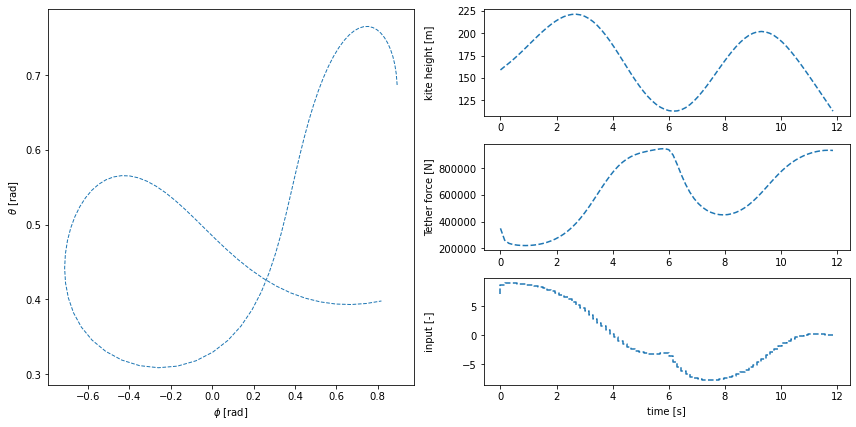

In [10]:
fig, ax = plot_update()

### Closed-loop trajectory

We are now ready to create a closed-loop MPC trajectory. Our main loop is intuitively written as shown below.
Note that we use ``%%capture`` to avoid the output from IPOPT in the Jupyter Notebook.

In [11]:
%%capture

n_steps = 200

for k in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

Display **closed-loop trajectory**:

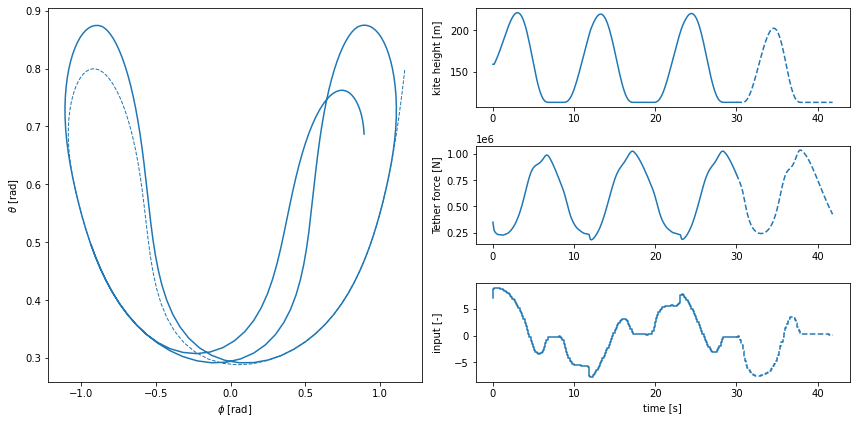

In [12]:
fig, ax = plot_update()

# Sampling

We use trajectories as the one shown above for data-based system identifaction with neural networks and Gaussian processes. 
To obtain a sufficient amount of data, we repeatedly simulate closed-loop trajectories with the nominal MPC controller. 
We use our own **do-mpc sampling tools** implementation with multiprocessing support to generate the data efficiently and in an organized fashion. 

For an introduction to the sampling tools implementation, we refer to this [video](https://www.youtube.com/watch?v=3ELyErkYPhE&t=3s) 